In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [4]:
from mlrl.experiments.train_maze_agent import (
    create_maze_meta_env, RestrictedActionsMazeState
)
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.environments.gym_wrapper import GymWrapper
from tf_agents.environments.batched_py_environment import BatchedPyEnvironment
from tf_agents.train.utils import spec_utils

args = {
    'agent': 'ppo', 
    'meta_time_limit': 500,
    'expand_all_actions': True
}
env_batch_size = 2

env = BatchedPyEnvironment([
    GymWrapper(create_maze_meta_env(RestrictedActionsMazeState, args)) 
    for _ in range(env_batch_size)
], multithreading=False)

eval_env = BatchedPyEnvironment([
    GymWrapper(create_maze_meta_env(RestrictedActionsMazeState, args)) 
    for _ in range(env_batch_size)
], multithreading=False)

env.reset()

observation_tensor_spec, action_tensor_spec, time_step_tensor_spec = (
      spec_utils.get_tensor_specs(env))

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1246:(snd_func_refer) error evaluating name
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5220:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:767:(parse_card) cannot find card '0'
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_card_driver returned error: No such file or directory
ALSA lib confmisc.c:392:(snd_func_concat) error evaluating strings
ALSA lib conf.c:4732:(_snd_config_evaluate) function snd_func_concat returned error: N

In [36]:
from mlrl.meta.search_networks import SearchTransformer

from official.nlp.modeling.layers import Transformer
from official.nlp.modeling.layers import transformer

from tf_agents.keras_layers import dynamic_unroll_layer
from tf_agents.networks import network
from tf_agents.networks import lstm_encoding_network
from tf_agents.trajectories import time_step
from tf_agents.utils import nest_utils
from tf_agents.specs import tensor_spec


class SearchRNNTransformer(network.Network):

    def __init__(self,
                 input_tensor_spec,
                 n_heads: int = 3,
                 n_transformer_layers: int = 3,
                 d_model: int = 64,
                 n_lstm_layers: int = 1,
                 name='search_rnn_transformer',
                 dtype=tf.float32,
                 **kwargs):
        super(SearchRNNTransformer, self).__init__(**kwargs)

        self.decoder_block = transformer.TransformerDecoderBlock(
            num_attention_heads=n_heads,
            intermediate_size=d_model*n_heads,
            intermediate_activation='relu',
            dropout_rate=0.1,
            attention_dropout_rate=0.1,
            use_bias=False,
            norm_first=True,
            norm_epsilon=1e-6,
            intermediate_dropout=0.1,
            attention_initializer=tf.keras.initializers.RandomUniform(
                minval=1., maxval=1.)
        )

        cell = tf.keras.layers.StackedRNNCells([
            tf.keras.layers.LSTMCell(d_model*n_heads, dtype=dtype,
                                     implementation=lstm_encoding_network.KERAS_LSTM_FUSED)
            for _ in range(n_lstm_layers)
        ])
        self.lstm_network = dynamic_unroll_layer.DynamicUnroll(cell)

        self.project_search_tokens = tf.keras.layers.Dense(
            d_model*n_heads, name='project_search_tokens'
        )

        self.transformer = SearchTransformer(
            n_heads=n_heads, n_layers=n_transformer_layers, d_model=d_model
        )

        counter = [-1]

        def create_spec(size):
            counter[0] += 1
            return tensor_spec.TensorSpec(
                size, dtype=dtype, name='network_state_%d' % counter[0])

        state_spec = tf.nest.map_structure(create_spec,
                                           self.lstm_network.cell.state_size)

        super(SearchRNNTransformer, self).__init__(
            input_tensor_spec=input_tensor_spec, state_spec=state_spec, name=name)


    def call(self, search_tokens, step_type, network_state=(), training=False):
        num_outer_dims = nest_utils.get_outer_rank(search_tokens,
                                                   self.input_tensor_spec)
        if num_outer_dims not in (1, 2):
            raise ValueError(
                'Input observation must have a batch or batch x time outer shape.')

        has_time_dim = num_outer_dims == 2
        if not has_time_dim:
            # Add a time dimension to the inputs.
            search_tokens = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1),
                                                  search_tokens)
            step_type = tf.nest.map_structure(lambda t: tf.expand_dims(t, 1),
                                              step_type)

        # resets network state for timesteps with step_type == FIRST
        network_kwargs = {
            'reset_mask': tf.equal(step_type, time_step.StepType.FIRST, name='mask')
        }

        # Prepare lstm inputs for each timestep.
        # This means using a decoder transformer layer from the search tokens at
        # each timestep to single token that servers as the input for the lstm.
        batch_size = tf.shape(search_tokens)[0]
        n_time_steps = tf.shape(search_tokens)[1]
        n_tokens = tf.shape(search_tokens)[2]

        # TODO: switch this to a tf.map_fn
        lstm_inputs_across_time = []
        for t in range(n_time_steps):
            inputs = tf.zeros((batch_size, 1, 192))
            decoder_inputs = [inputs, search_tokens[:, t], None, None]
            lstm_inputs, _ = self.decoder_block(decoder_inputs)
            lstm_inputs_across_time.append(lstm_inputs)

        lstm_inputs_across_time = tf.concat(lstm_inputs_across_time, axis=1)

        # Apply inputs and network state to the lstm
        memory_encoding, network_state = self.lstm_network(
            inputs=lstm_inputs_across_time,
            initial_state=network_state,
            training=training,
            **network_kwargs)

        # reshape the output of the lstm to be added to each of the search tokens
        # thus encorporating information from previous timesteps into the tokens
        memory_encoding = tf.expand_dims(memory_encoding, 2)
        memory_encoding = tf.repeat(memory_encoding, n_tokens, axis=2)

        tokens = self.project_search_tokens(search_tokens)
        tokens = tokens + memory_encoding

        # swap the time and batch dimensions to be able to apply the transformer
        # to each of the token sets across time
        tokens = tf.einsum('btnd->tbnd', tokens)
        tokens = tf.map_fn(self.transformer, tokens)
        tokens = tf.einsum('tbnd->btnd', tokens)

        if not has_time_dim:
            # Remove time dimension from the state.
            tokens = tf.squeeze(tokens, [1])

        return tokens, network_state

In [37]:
from mlrl.meta.meta_env import MetaEnv
from tf_agents.train.utils import spec_utils

observation_tensor_spec, action_tensor_spec, time_step_tensor_spec = (
    spec_utils.get_tensor_specs(env))

search_rrn_transformer = SearchRNNTransformer(observation_tensor_spec[MetaEnv.SEARCH_TOKENS_KEY])

In [38]:
ts = env.current_time_step()
search_tokens = tf.convert_to_tensor(ts.observation[MetaEnv.SEARCH_TOKENS_KEY])
step_type = tf.convert_to_tensor(ts.step_type)
network_state = ()

In [39]:
output_tokens, network_state = search_rrn_transformer(search_tokens, step_type, network_state)
output_tokens.shape, tf.shape(network_state)

(TensorShape([2, 11, 192]),
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1,   2,   2, 192], dtype=int32)>)

In [45]:
class ValueSearchRNN(network.Network):

    def __init__(self,
            input_tensor_spec,
            name='value_search_rnn'):

        self.transformer = SearchRNNTransformer(observation_tensor_spec[MetaEnv.SEARCH_TOKENS_KEY])

        self.to_value = tf.keras.layers.Dense(
            1,
            activation=None,
            kernel_initializer=tf.random_uniform_initializer(
                minval=-0.03, maxval=0.03))

        super(ValueSearchRNN, self).__init__(
            input_tensor_spec=input_tensor_spec,
            state_spec=self.transformer.state_spec,
            name=name)

    def compute_value(self,
                      search_tokens,
                      step_type,
                      network_state=(),
                      training=False):

        tokens, network_state = self.transformer(search_tokens,
                                                 step_type=step_type,
                                                 network_state=network_state,
                                                 training=training)
        x = tf.reduce_sum(tokens, axis=-2)
        return tf.squeeze(self.to_value(x), axis=-1), network_state

    def call(self,
             observation,
             step_type=None,
             network_state=(),
             training=False):

        if tf.nest.is_nested(observation):
            tokens = observation[MetaEnv.SEARCH_TOKENS_KEY]
        else:
            tokens = observation

        return self.compute_value(tokens, step_type, network_state, training=training)

In [41]:
value_search_rnn = ValueSearchRNN(observation_tensor_spec)

In [42]:
ts = TFPyEnvironment(env).current_time_step()
obs = ts.observation
step_type = ts.step_type
network_state = ()

In [43]:
values, network_state = value_search_rnn(obs, step_type=step_type, network_state=network_state)
values, tf.shape(network_state)

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.670563, 2.670563], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1,   2,   2, 192], dtype=int32)>)

In [15]:
ds = dataset_fn()

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [16]:
traj, buffer_info = next(iter(ds))

In [17]:
tokens = traj.observation[MetaEnv.SEARCH_TOKENS_KEY]
step_type = traj.step_type
states = ()

In [44]:
values, states = value_search_rnn(traj.observation, step_type=traj.step_type, network_state=states)
values.shape, values[:2, :10]

(TensorShape([4, 64]),
 <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
 array([[2.7042155, 1.8551035, 2.229851 , 2.0592315, 2.113766 , 2.0915146,
         2.0498035, 2.0507686, 2.670562 , 2.3779268],
        [2.4532359, 2.670562 , 2.3779268, 2.2913864, 2.3352098, 2.1262205,
         2.184648 , 2.4280472, 2.4497213, 2.448189 ]], dtype=float32)>)

In [64]:
import tensorflow_probability as tfp


class ActionSearchRNN(network.Network):

    def __init__(self,
                 input_tensor_spec,
                 name='action_search_rnn'):

        self.transformer = SearchRNNTransformer(observation_tensor_spec[MetaEnv.SEARCH_TOKENS_KEY])

        self.to_logit = tf.keras.layers.Dense(
            1,
            activation=None,
            kernel_initializer=tf.random_uniform_initializer(
                minval=-0.03, maxval=0.03))

        super(ActionSearchRNN, self).__init__(
            input_tensor_spec=input_tensor_spec,
            state_spec=self.transformer.state_spec,
            name=name)

    def call(self,
            observation,
            step_type=None,
            network_state=(),
            training=False):

        if tf.nest.is_nested(observation):
            tokens = observation[MetaEnv.SEARCH_TOKENS_KEY]
            mask = tf.cast(observation[MetaEnv.ACTION_MASK_KEY], tf.bool)
        else:
            tokens = observation

        tokens, network_state = self.transformer(tokens,
                                                 step_type=step_type,
                                                 network_state=network_state,
                                                 training=training)
        
        action_logits = tf.squeeze(self.to_logit(tokens, training=training), -1)
        action_logits = tf.where(mask, action_logits, tf.float32.min)

        action_distribution = tfp.distributions.Categorical(
            logits=action_logits, dtype=tf.int64
        )
        return action_distribution, network_state

In [65]:
action_search_rnn = ActionSearchRNN(observation_tensor_spec)

In [66]:
states = ()

In [67]:
action_dist, states = action_search_rnn(traj.observation, step_type=traj.step_type, network_state=states)
action_dist

<tfp.distributions.Categorical 'Categorical' batch_shape=[4, 64] event_shape=[] dtype=int64>

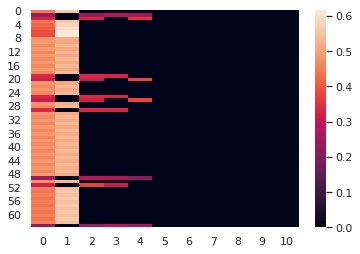

In [71]:
sns.heatmap(tf.nn.softmax(action_dist.logits[0]));

In [70]:
action_dist.sample()

<tf.Tensor: shape=(4, 64), dtype=int64, numpy=
array([[1, 3, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 4, 1,
        1, 0, 1, 3, 0, 1, 1, 3, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 3, 0, 2, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 4],
       [1, 0, 1, 1, 1, 3, 2, 0, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 4, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 1],
       [1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1]])>

In [72]:
from tf_agents.agents.ppo.ppo_agent import PPOAgent
from tf_agents.train.utils import train_utils
from tf_agents.networks.mask_splitter_network import MaskSplitterNetwork

from mlrl.meta.meta_env import mask_token_splitter
from mlrl.meta.search_networks import create_action_distribution_network
from mlrl.meta.search_networks import create_value_network

train_step = train_utils.create_train_step()

# network_kwargs = {
#     'n_heads': 3,
#     'n_layers': 2,
#     'd_model': 32,
# }

# value_net = create_value_network(observation_tensor_spec, **network_kwargs)

# actor_net = create_action_distribution_network(observation_tensor_spec['search_tree_tokens'],
#                                                action_tensor_spec,
#                                                **network_kwargs)

# masked_actor_net = MaskSplitterNetwork(mask_token_splitter,
#                                        actor_net,
#                                        input_tensor_spec=observation_tensor_spec,
#                                        passthrough_mask=True)


agent = PPOAgent(
    time_step_tensor_spec,
    action_tensor_spec,
    actor_net=action_search_rnn,
    value_net=value_search_rnn,
    optimizer=tf.keras.optimizers.Adam(3e-4),
    train_step_counter=train_step,
    compute_value_and_advantage_in_train=False,
    update_normalizers_in_train=False,
    normalize_observations=False,
    discount_factor=0.99,
    num_epochs=1,  # deprecated param
)

In [74]:
agent.collect_policy._policy_state_spec

{'actor_network_state': (ListWrapper([TensorSpec(shape=(192,), dtype=tf.float32, name='network_state_0'), TensorSpec(shape=(192,), dtype=tf.float32, name='network_state_1')]),),
 'value_network_state': (ListWrapper([TensorSpec(shape=(192,), dtype=tf.float32, name='network_state_0'), TensorSpec(shape=(192,), dtype=tf.float32, name='network_state_1')]),)}

In [89]:
import imageio

def create_policy_eval_video(policy,
                             env,
                             filename: str = 'video',
                             max_steps: int = 60,
                             max_envs_to_show: int = 2,
                             fps: int = 1) -> str:
    """
    Creates and saves a video of the policy being evaluating in an environment.

    Args:
        policy (TFPolicy): The policy to evaluate.
        env (TFEnvironment): The environment to evaluate the policy in.
        filename (str): The name of the file to save the video to.
        max_steps (int): The maximum number of steps to run the policy for.
        fps (int): The frames per second of the video.

    Returns:
        str: The path to the saved video.
    """
    if not filename.endswith('.mp4'):
        filename = filename + '.mp4'

    env.reset()

    policy_state = policy.get_initial_state(env.batch_size)

    def render_env(i):
        gym_env = env.envs[i].gym
        policy_step = policy.distribution(env.current_time_step(), policy_state)
        if isinstance(policy_step.action, tfp.distributions.Categorical):
            probs = tf.nn.softmax(policy_step.action.logits[i]).numpy()
            return gym_env.render(meta_action_probs=probs)
        return gym_env.render()

    def get_image() -> np.array:
        if hasattr(env, 'envs'):
            imgs = np.array([
                render_env(i)
                for i in range(max_envs_to_show)
            ])
            b, h, w, c = imgs.shape
            return imgs.reshape((b * h, w, c))
        return env.render()

    with imageio.get_writer(filename, fps=fps, macro_block_size=1) as video:

        video.append_data(get_image())

        for _ in range(max_steps):
            action_step = policy.action(env.current_time_step(), policy_state)
            policy_state = action_step.state
            env.step(action_step.action)
            video.append_data(get_image())

    return filename

In [91]:
# from mlrl.utils.render_utils import create_policy_eval_video, embed_mp4

embed_mp4(create_policy_eval_video(agent.collect_policy, TFPyEnvironment(eval_env), max_steps=30))

In [13]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=env.batch_size or 1,
    max_length=10000
)


def preprocess_seq(experience, info):
    return agent.preprocess_sequence(experience), info


def dataset_fn():
    ds = replay_buffer.as_dataset(sample_batch_size=4, num_steps=64)
    return ds.map(preprocess_seq).prefetch(5)

In [14]:
from tf_agents.train import actor
from tf_agents.train import learner
from tf_agents.metrics import py_metrics
from tf_agents.train import triggers

import os

root_dir = './runs/ppo_agent/test'

summary_interval = 1000
collect_sequence_length = 2048
policy_save_interval = 5000


saved_model_dir = os.path.join(root_dir, learner.POLICY_SAVED_MODEL_DIR)
collect_env_step_metric = py_metrics.EnvironmentSteps()
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        agent,
        train_step,
        interval=policy_save_interval,
        metadata_metrics={
            triggers.ENV_STEP_METADATA_KEY: collect_env_step_metric
        }),
    triggers.StepPerSecondLogTrigger(train_step, interval=summary_interval),
]

collect_actor = actor.Actor(
    env,
    agent.collect_policy,
    train_step,
    steps_per_run=collect_sequence_length,
    observers=[replay_buffer.add_batch],
    metrics=actor.collect_metrics(buffer_size=collect_sequence_length),
    reference_metrics=[collect_env_step_metric],
    summary_dir=os.path.join(root_dir, learner.TRAIN_DIR),
    summary_interval=summary_interval)

collect_actor.run()

In [6]:
from tf_agents.policies import py_tf_eager_policy

eval_steps=1000

eval_greedy_policy = py_tf_eager_policy.PyTFEagerPolicy(
    agent.policy, use_tf_function=True)

eval_actor = actor.Actor(
    eval_env,
    eval_greedy_policy,
    train_step,
    metrics=actor.eval_metrics(buffer_size=10),
    reference_metrics=[collect_env_step_metric],
    summary_dir=os.path.join(root_dir, 'eval'),
    steps_per_run=eval_steps)

# eval_actor.run_and_log()

In [7]:
from tf_agents.train.ppo_learner import PPOLearner

ppo_learner = PPOLearner(
    root_dir,
    train_step,
    agent,
    experience_dataset_fn=dataset_fn,
    normalization_dataset_fn=dataset_fn,
    num_samples=1, num_epochs=20,  # num samples * num epochs = num iterations per run call
    triggers=learning_triggers,
    shuffle_buffer_size=collect_sequence_length
)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [8]:
import wandb
from mlrl.utils.render_utils import create_policy_eval_video


videos_dir = root_dir + '/videos'

from pathlib import Path
Path(videos_dir).mkdir(parents=True, exist_ok=True) 


eval_interval = 5
num_iterations = 100

try:
      config = {
            'name': '5x5_maze_ppo',
            'eval_interval': eval_interval,
            'num_iterations': num_iterations,
            'summary_interval': summary_interval,
            'collect_sequence_length': collect_sequence_length,
            'policy_save_interval': policy_save_interval,
            'num_samples': ppo_learner._num_samples,
            'num_epochs': ppo_learner._num_epochs,
            'meta_discount_factor': agent._discount_factor,
            'max_tree_size': env.envs[0].max_tree_size,
            'env_batch_size': env.batch_size,
      }

      wandb.init(project='mlrl', entity='drcope', reinit=True, config=config)

      for i in range(num_iterations):
            iteration_logs = {'iteration': i}

            print(f'Iteration: {i}')

            # its very important to reset the actors
            # otherwise the observations can be wrong on the next run
            collect_actor.reset()
            eval_actor.reset()
            for metric in eval_actor.metrics:
                  metric.reset()
            for metric in collect_actor.metrics:
                  metric.reset()

            if i % eval_interval == 0:
                  eval_actor.run_and_log()
                  print('Evaluation stats:')
                  print(', '.join([f'{metric.name}: {metric.result():.3f}' for metric in eval_actor.metrics]))
                  iteration_logs.update({f'Eval{metric.name}': metric.result() for metric in eval_actor.metrics})

                  try:
                        video_file = f'{videos_dir}/video_{i}.mp4'
                        create_policy_eval_video(agent.policy, env, max_steps=120,
                                                 filename=video_file, max_envs_to_show=1)
                        iteration_logs['video'] = wandb.Video(video_file, fps=30, format="mp4")
                  except Exception as e:
                        print(f'Error creating video: {e}')

            collect_actor.run()
            print('Collect stats:')
            print(', '.join([f'{metric.name}: {metric.result():.3f}' for metric in collect_actor.metrics]))
            iteration_logs.update({metric.name: metric.result() for metric in collect_actor.metrics})

            loss_info = ppo_learner.run()
            print('Training info:')
            print(f'Loss: {loss_info.loss:.5f}, '
                  f'KL Penalty Loss: {loss_info.extra.kl_penalty_loss:.5f}, '
                  f'Entropy: {loss_info.extra.entropy_regularization_loss:.5f}, '
                  f'Value Estimation Loss: {loss_info.extra.value_estimation_loss:.5f}, '
                  f'PG Loss {loss_info.extra.policy_gradient_loss:.5f}')

            iteration_logs.update({
                  'loss': loss_info.loss.numpy(), 
                  **tf.nest.map_structure(lambda x: x.numpy(), loss_info.extra._asdict())
            })

            print()

            wandb.log(iteration_logs)
            replay_buffer.clear()

finally:
      wandb.finish()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.13.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Iteration: 0
Collect stats:
NumberOfEpisodes: 32.000, EnvironmentSteps: 2048.000, AverageReturn: 0.955, AverageEpisodeLength: 62.938
Training info:
Loss: 0.92742, KL Penalty Loss: 0.01046, Entropy: 0.00000, Value Estimation Loss: 0.95825, PG Loss -0.04129
Evaluation stats:
AverageReturn: 0.953, AverageEpisodeLength: 80.000



Iteration: 1
Collect stats:
NumberOfEpisodes: 30.000, EnvironmentSteps: 2048.000, AverageReturn: 0.946, AverageEpisodeLength: 66.700
Training info:
Loss: 0.47094, KL Penalty Loss: 0.00043, Entropy: 0.00000, Value Estimation Loss: 0.54559, PG Loss -0.07508

Iteration: 2
Collect stats:
NumberOfEpisodes: 30.000, EnvironmentSteps: 2048.000, AverageReturn: 0.953, AverageEpisodeLength: 65.600
Training info:
Loss: 0.10185, KL Penalty Loss: 0.00122, Entropy: 0.00000, Value Estimation Loss: 0.16324, PG Loss -0.06261

Iteration: 3
Collect stats:
NumberOfEpisodes: 34.000, EnvironmentSteps: 2048.000, AverageReturn: 0.956, AverageEpisodeLength: 59.765
Training info:
Loss: 0.11847, KL Penalty Loss: 0.00749, Entropy: 0.00000, Value Estimation Loss: 0.21133, PG Loss -0.10034

Iteration: 4
Collect stats:
NumberOfEpisodes: 31.000, EnvironmentSteps: 2049.000, AverageReturn: 0.954, AverageEpisodeLength: 63.581
Training info:
Loss: -0.00721, KL Penalty Loss: 0.00319, Entropy: 0.00000, Value Estimation Los

Evaluation stats:
AverageReturn: 0.953, AverageEpisodeLength: 80.000

Iteration: 6
Collect stats:
NumberOfEpisodes: 34.000, EnvironmentSteps: 2048.000, AverageReturn: 0.962, AverageEpisodeLength: 57.559
Training info:
Loss: 0.03863, KL Penalty Loss: 0.00297, Entropy: 0.00000, Value Estimation Loss: 0.14078, PG Loss -0.10512

Iteration: 7
Collect stats:
NumberOfEpisodes: 33.000, EnvironmentSteps: 2049.000, AverageReturn: 0.960, AverageEpisodeLength: 58.879
Training info:
Loss: 0.01563, KL Penalty Loss: 0.00520, Entropy: 0.00000, Value Estimation Loss: 0.14271, PG Loss -0.13228

Iteration: 8
Collect stats:
NumberOfEpisodes: 32.000, EnvironmentSteps: 2048.000, AverageReturn: 0.959, AverageEpisodeLength: 62.469
Training info:
Loss: 0.03292, KL Penalty Loss: 0.00018, Entropy: 0.00000, Value Estimation Loss: 0.15136, PG Loss -0.11862

Iteration: 9
Collect stats:
NumberOfEpisodes: 35.000, EnvironmentSteps: 2049.000, AverageReturn: 0.969, AverageEpisodeLength: 55.400
Training info:
Loss: -0.02


Iteration: 11
Collect stats:
NumberOfEpisodes: 37.000, EnvironmentSteps: 2048.000, AverageReturn: 0.959, AverageEpisodeLength: 54.541
Training info:
Loss: 0.02425, KL Penalty Loss: 0.00001, Entropy: 0.00000, Value Estimation Loss: 0.13519, PG Loss -0.11095

Iteration: 12
Collect stats:
NumberOfEpisodes: 42.000, EnvironmentSteps: 2049.000, AverageReturn: 0.975, AverageEpisodeLength: 47.095
Training info:
Loss: 0.03540, KL Penalty Loss: 0.00062, Entropy: 0.00000, Value Estimation Loss: 0.17071, PG Loss -0.13593

Iteration: 13
Collect stats:
NumberOfEpisodes: 43.000, EnvironmentSteps: 2049.000, AverageReturn: 0.972, AverageEpisodeLength: 46.605
Training info:
Loss: 0.19583, KL Penalty Loss: 0.00498, Entropy: 0.00000, Value Estimation Loss: 0.27726, PG Loss -0.08642

Iteration: 14
Collect stats:
NumberOfEpisodes: 43.000, EnvironmentSteps: 2049.000, AverageReturn: 0.972, AverageEpisodeLength: 45.558
Training info:
Loss: -0.01204, KL Penalty Loss: 0.00729, Entropy: 0.00000, Value Estimation


Iteration: 16
Collect stats:
NumberOfEpisodes: 49.000, EnvironmentSteps: 2049.000, AverageReturn: 0.982, AverageEpisodeLength: 41.592
Training info:
Loss: 0.08427, KL Penalty Loss: 0.00109, Entropy: 0.00000, Value Estimation Loss: 0.16816, PG Loss -0.08498

Iteration: 17
Collect stats:
NumberOfEpisodes: 49.000, EnvironmentSteps: 2049.000, AverageReturn: 0.982, AverageEpisodeLength: 40.816
Training info:
Loss: -0.10123, KL Penalty Loss: 0.00000, Entropy: 0.00000, Value Estimation Loss: 0.07922, PG Loss -0.18046

Iteration: 18
Collect stats:
NumberOfEpisodes: 54.000, EnvironmentSteps: 2048.000, AverageReturn: 0.987, AverageEpisodeLength: 37.259
Training info:
Loss: -0.09559, KL Penalty Loss: 0.01591, Entropy: 0.00000, Value Estimation Loss: 0.07045, PG Loss -0.18195

Iteration: 19
Collect stats:
NumberOfEpisodes: 56.000, EnvironmentSteps: 2048.000, AverageReturn: 0.982, AverageEpisodeLength: 36.089
Training info:
Loss: 0.00144, KL Penalty Loss: 0.00000, Entropy: 0.00000, Value Estimatio

Evaluation stats:
AverageReturn: 0.996, AverageEpisodeLength: 37.000

Iteration: 21
Collect stats:
NumberOfEpisodes: 57.000, EnvironmentSteps: 2049.000, AverageReturn: 0.992, AverageEpisodeLength: 34.807
Training info:
Loss: -0.02823, KL Penalty Loss: 0.00000, Entropy: 0.00000, Value Estimation Loss: 0.09493, PG Loss -0.12315

Iteration: 22
Collect stats:
NumberOfEpisodes: 68.000, EnvironmentSteps: 2048.000, AverageReturn: 0.997, AverageEpisodeLength: 29.838
Training info:
Loss: -0.03970, KL Penalty Loss: 0.00193, Entropy: 0.00000, Value Estimation Loss: 0.10951, PG Loss -0.15115

Iteration: 23
Collect stats:
NumberOfEpisodes: 76.000, EnvironmentSteps: 2048.000, AverageReturn: 0.998, AverageEpisodeLength: 26.408
Training info:
Loss: -0.06981, KL Penalty Loss: 0.01519, Entropy: 0.00000, Value Estimation Loss: 0.08551, PG Loss -0.17051

Iteration: 24
Collect stats:
NumberOfEpisodes: 93.000, EnvironmentSteps: 2049.000, AverageReturn: 1.003, AverageEpisodeLength: 21.699
Training info:
Loss

Evaluation stats:
AverageReturn: 1.022, AverageEpisodeLength: 11.000

Iteration: 26
Waiting for debugger attach
Debugger attached


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


AverageEpisodeLength,▇██▇█▇▇▇▇▆▇▆▅▅▅▄▄▄▃▃▃▃▂▂▁▁
AverageReturn,▂▁▂▂▂▃▃▃▃▄▂▃▅▄▄▅▅▅▆▅▆▇▇▇██
EnvironmentSteps,▁▁▁▁██▁█▁█▁▁███▁██▁▁██▁▁██
EvalAverageEpisodeLength,███▆▄▁
EvalAverageReturn,▁▁▁▃▅█
NumberOfEpisodes,▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▃▃▃▄▄▄▄▅▆██
entropy_regularization_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
kl_penalty_loss,▆▁▂▄▂▂▂▃▁▂▁▁▁▃▄▁▁▁█▁▁▁▂█▂▁
l2_regularization_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▁▁▂▁▁▁▁▁▁


IndexError: list index out of range